# Homework 5
### Marco Sicklinger, April 2021

### Packages & modules

In [4]:
import torch
from scripts import mnist, train_utils, architectures, train
from scripts.train_utils import accuracy, AverageMeter
from scripts.torch_utils import use_gpu_if_possible

## Enhancement of the `magnitude_pruning` routine

First we define the network we want to work with:

In [5]:
layers = [
    {"n_in": 784, "n_out": 16, "batchnorm": False},
    {"n_out": 32, "batchnorm": True},
    {"n_out": 64, "batchnorm": True},
    {"n_out": 10, "batchnorm": True}
]
net = architectures.MLPCustom(layers)

In [6]:
for par in net.named_parameters():
    print(par[0], par[1].shape)

layers.1.weight torch.Size([16, 784])
layers.1.bias torch.Size([16])
layers.3.weight torch.Size([16])
layers.3.bias torch.Size([16])
layers.4.weight torch.Size([32, 16])
layers.4.bias torch.Size([32])
layers.6.weight torch.Size([32])
layers.6.bias torch.Size([32])
layers.7.weight torch.Size([64, 32])
layers.7.bias torch.Size([64])
layers.9.weight torch.Size([64])
layers.9.bias torch.Size([64])
layers.10.weight torch.Size([10, 64])
layers.10.bias torch.Size([10])


In order to make consecutive calls of the `magnitude_pruning` function sensible, it is necessary to insert a procedure according to which the values of the already pruned parameters are not considered when compunting a new threshold, which will be used in a new pruning step. I implemented this idea by removing from the distribution of the parameters' elements of the model those elements that were set to zero during the previous pruning step, so that only the distribution of the non-pruned parameters remains.

In [7]:
def magnitude_pruning(model, pruning_rate, old_mask=None, layers_to_prune=["1","4","7","10"]):
    # 0. parameters to be pruned
    pars_to_prune = [pars for pars in model.named_parameters() if any([l in pars[0] for l in layers_to_prune])] 
    # 1. vectorize distribution of abs(parameter)
    flat = torch.cat([pars[1].abs().flatten() for pars in pars_to_prune], dim=0)
    # 1b. if current pruning process is not the first of a sequence of pruning processes,
    #     remove all elements (parameters' elements) that have been already pruned, so that
    #     the process of choosing the threshold can rely on the non-zero elements only 
    if old_mask is not None:
        flat = flat[flat.nonzero()].reshape(flat[flat.nonzero()].shape[0])
    # 2. sort this distribution
    flat = flat.sort()[0]
    # 3. obtain the threshold
    position = int(pruning_rate*flat.shape[0])
    thresh = flat[position]
    # 4. binarize the parameters & 5. compose these booleans into the mask
    mask = [torch.where(pars[1].abs() >= thresh, torch.ones(pars[1].shape), torch.zeros(pars[1].shape)) for pars in pars_to_prune]
    # 6. obtain the new structure of parameters
    for pars, m in zip(pars_to_prune, mask):
        pars[1].data *= m
    # 7. what do we need to return? we need to store the mask
    return mask, pars_to_prune

### First check 

In this section we check if the implementation of the enhanced `magnitude_pruning` routine runs and its results make sense. Consider the following pruning rate

In [8]:
pruning_rate = 0.2

By applying the `magnitude_pruning` function, it is possible to observe that the computed masks are compatible (in terms of sizes) with the model parameters that the user wants to prune.

In [9]:
mask_1, pars_to_prune = magnitude_pruning(net, pruning_rate)
for par,m in zip(pars_to_prune,mask_1):
    print('par: ', par[1].shape, ' m: ',m.shape,'\n')

par:  torch.Size([16, 784])  m:  torch.Size([16, 784]) 

par:  torch.Size([16])  m:  torch.Size([16]) 

par:  torch.Size([32, 16])  m:  torch.Size([32, 16]) 

par:  torch.Size([32])  m:  torch.Size([32]) 

par:  torch.Size([64, 32])  m:  torch.Size([64, 32]) 

par:  torch.Size([64])  m:  torch.Size([64]) 

par:  torch.Size([10, 64])  m:  torch.Size([10, 64]) 

par:  torch.Size([10])  m:  torch.Size([10]) 



In [10]:
mask_2, pars_to_prune = magnitude_pruning(net, pruning_rate, old_mask=mask_1)
for par,m in zip(pars_to_prune,mask_2):
    print('par: ', par[1].shape, ' m: ',m.shape,'\n')

par:  torch.Size([16, 784])  m:  torch.Size([16, 784]) 

par:  torch.Size([16])  m:  torch.Size([16]) 

par:  torch.Size([32, 16])  m:  torch.Size([32, 16]) 

par:  torch.Size([32])  m:  torch.Size([32]) 

par:  torch.Size([64, 32])  m:  torch.Size([64, 32]) 

par:  torch.Size([64])  m:  torch.Size([64]) 

par:  torch.Size([10, 64])  m:  torch.Size([10, 64]) 

par:  torch.Size([10])  m:  torch.Size([10]) 



In order to check if the second application of `magnitude_prunig` has given a different mask (meaning, a mask that is going to "shadow" more parameters' elements of the previous one), we define a function that counts the number of zero elements of a pytorch tensor. 

In [11]:
def count_zeros(Tensor):
    zeros = torch.sum(Tensor == 0).item()
    return zeros

Then we compute the number of zeros in the two computed masks.

In [12]:
zeros_mask_1 = 0
zeros_mask_2 = 0
for m1, m2 in zip(mask_1, mask_2):
    zeros_mask_1 += count_zeros(m1)
    zeros_mask_2 += count_zeros(m2)
print('zeros in mask 1: ',zeros_mask_1 , '| --- |', 'zeros in mask 2: ', zeros_mask_2)

zeros in mask 1:  3173 | --- | zeros in mask 2:  5711


**Observation:** The total number of parameters that are to be pruned is $15866$. We set the pruning rate at $20%$ and, indeed, the pruned parameters are the integer part of $15866\cdot0.2$, that is $3173$.
The remaining are $15866-3173=12693$. Pruning again takes out $5711-3173=2538$ elements, which is actually the integer part of the $20\%$ fo $12693$.

## Second check, with training

Let's consider the previous model, pre-trained on the 'MNIST' dataset.

In [243]:
layers = [
    {"n_in": 784, "n_out": 16, "batchnorm": False},
    {"n_out": 32, "batchnorm": True},
    {"n_out": 64, "batchnorm": True},
    {"n_out": 10, "batchnorm": True}
]
net = architectures.MLPCustom(layers)

In [244]:
trainloader, testloader, _, _ = mnist.get_data()
loss_fn = torch.nn.CrossEntropyLoss()

In [245]:
# load pretrained model
state_dict = torch.load("models_push/mlp_custom_mnist/mlp_custom_mnist.pt")
net.load_state_dict(state_dict)
train.test_model(net, testloader, loss_fn=loss_fn)

TESTING - loss 7349.624578475952 - performance 0.9631333333333333


(7349.624578475952, 0.9631333333333333)

The `train_epoch` and `train_model` function have been suitably modified in order to take as an additional parameter the list of parameters that are to be pruned, so that it is possible to avoid that also pruned elements are trained (inside `train_epoch` routine). The aforementioned parameter is set to `None` by default, but one can pass the wanted list of parameters that is returned by the `magnitude_pruning` function.

In [20]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, device, mask, pars_to_prune):
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad() 

        y_hat = model(X)

        loss = loss_fn(y_hat, y)

        loss.backward()

        ##### we must neutralize the gradient on the pruned params before the optimizer takes a step ####

        if mask is not None:
            for pars, m in zip(pars_to_prune, mask):
                pars[1].grad *= m

        ######

        optimizer.step()

        acc = performance(y_hat, y)

        loss_meter.update(val=loss.item(), n=X.shape[0])
        performance_meter.update(val=acc, n=X.shape[0])

In [21]:
def train_model(model, dataloader, loss_fn, optimizer, num_epochs, checkpoint_loc=None, checkpoint_name="checkpoint.pt", performance=accuracy, lr_scheduler=None, device=None, mask=None, pars_to_prune=None):
    if checkpoint_loc is not None:
        os.makedirs(checkpoint_loc, exist_ok=True)

    if device is None:
        device = use_gpu_if_possible()
    
    model = model.to(device)
    model.train()

    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        performance_meter = AverageMeter()

        print(f"Epoch {epoch+1} --- learning rate {optimizer.param_groups[0]['lr']:.5f}")

        train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, device, mask, pars_to_prune)

        print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}; Performance: {performance_meter.avg}")

        if checkpoint_name is not None and checkpoint_loc is not None:
            checkpoint_dict = {
                "parameters": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch
            }
            torch.save(checkpoint_dict, os.path.join(checkpoint_loc, checkpoint_name))
        
        if lr_scheduler is not None:
            lr_scheduler.step()

    return loss_meter.sum, performance_meter.avg

In [248]:
learning_rate = 0.01
num_epochs = 10
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

In [249]:
pruning_rate = 0.2
mask, pars_to_prune = magnitude_pruning(net, pruning_rate)

In [250]:
# counting of zeros at the "starting point" mask
zeros_mask_first = 0
for m in mask:
    zeros_mask_first += count_zeros(m)
print('zeros in first mask: ', zeros_mask_first)

zeros in first mask:  3173


In [251]:
losses = []
accuracies = []
iterations = 10
mask_last = None
for i in range(iterations):
    l, a = train_model(net, trainloader, loss_fn, optimizer, num_epochs, mask=mask, pars_to_prune=pars_to_prune)
    losses.append(l)
    accuracies.append(a)
    mask, pars_to_prune = magnitude_pruning(net, pruning_rate, old_mask=mask)
    mask_last = mask
    zeros_mask_last = 0
    for m in mask_last:
        zeros_mask_last += count_zeros(m)
    print('zeros in final mask: ', zeros_mask_last)
    print('Iteration {} completed'.format(i+1))
    print('----------------------')

Epoch 1 --- learning rate 0.01000
Epoch 1 completed. Loss - total: 12338.451662063599 - average: 0.2056408610343933; Performance: 0.9370166666666667
Epoch 2 --- learning rate 0.01000
Epoch 2 completed. Loss - total: 9092.570098400116 - average: 0.15154283497333526; Performance: 0.95355
Epoch 3 --- learning rate 0.01000
Epoch 3 completed. Loss - total: 8026.804535150528 - average: 0.13378007558584212; Performance: 0.9583166666666667
Epoch 4 --- learning rate 0.01000
Epoch 4 completed. Loss - total: 7246.538192749023 - average: 0.12077563654581706; Performance: 0.9623166666666667
Epoch 5 --- learning rate 0.01000
Epoch 5 completed. Loss - total: 6583.903876066208 - average: 0.10973173126777012; Performance: 0.9653166666666667
Epoch 6 --- learning rate 0.01000
Epoch 6 completed. Loss - total: 6213.696259975433 - average: 0.10356160433292388; Performance: 0.9672333333333333
Epoch 7 --- learning rate 0.01000
Epoch 7 completed. Loss - total: 5983.215481758118 - average: 0.09972025802930196; 

In [253]:
import matplotlib.pyplot as plt

In [254]:
axis = [i+1 for i in range(iterations)]
one = [1 for i in range(iterations)]
zero = [0 for i in range(iterations)]

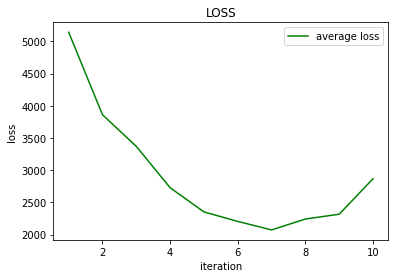

In [255]:
_ = plt.plot(axis, losses, label = 'average loss', color = 'green')
__ = plt.xlabel('iteration') 
___ = plt.ylabel('loss')
____ = plt.title('LOSS')
_____ = plt.legend()

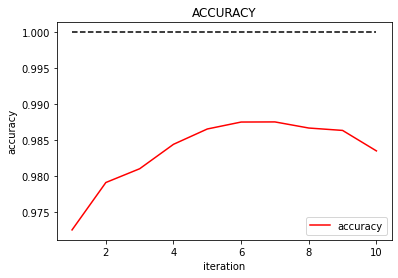

In [256]:
_ = plt.plot(axis, one, linestyle = 'dashed', color = 'black')
_ = plt.plot(axis, accuracies, label = 'accuracy', color = 'red')
__ = plt.xlabel('iteration') 
___ = plt.ylabel('accuracy')
____ = plt.title('ACCURACY')
_____ = plt.legend()

**Observation:** It is possible to notice that pruning to much decreases performaces.

## Pruning with lower pruning rate

Given the last observation, we now try to prune with lower pruning rate.

In [30]:
layers = [
    {"n_in": 784, "n_out": 16, "batchnorm": False},
    {"n_out": 32, "batchnorm": True},
    {"n_out": 64, "batchnorm": True},
    {"n_out": 10, "batchnorm": True}
]
net = architectures.MLPCustom(layers)

In [31]:
trainloader, testloader, _, _ = mnist.get_data()
loss_fn = torch.nn.CrossEntropyLoss()

In [32]:
# load pretrained model
state_dict = torch.load("models_push/mlp_custom_mnist/mlp_custom_mnist.pt")
net.load_state_dict(state_dict)
train.test_model(net, testloader, loss_fn=loss_fn)

TESTING - loss 7349.624578475952 - performance 0.9631333333333333


(7349.624578475952, 0.9631333333333333)

In [33]:
learning_rate = 0.01
num_epochs = 15
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

In [34]:
pruning_rate = 0.05
mask, pars_to_prune = magnitude_pruning(net, pruning_rate)

In [35]:
# counting of zeros at the "starting point" mask
zeros_mask_first = 0
for m in mask:
    zeros_mask_first += count_zeros(m)
print('zeros in first mask: ', zeros_mask_first)

zeros in first mask:  793


In [36]:
losses = []
accuracies = []
iterations = 15
mask_last = None
for i in range(iterations):
    l, a = train_model(net, trainloader, loss_fn, optimizer, num_epochs, mask=mask, pars_to_prune=pars_to_prune)
    losses.append(l)
    accuracies.append(a)
    mask, pars_to_prune = magnitude_pruning(net, pruning_rate, old_mask=mask)
    mask_last = mask
    zeros_mask_last = 0
    for m in mask_last:
        zeros_mask_last += count_zeros(m)
    print('zeros in last mask: ', zeros_mask_last)
    print('Iteration {} completed'.format(i+1))
    print('----------------------')

Epoch 1 --- learning rate 0.01000
Epoch 1 completed. Loss - total: 13109.16258096695 - average: 0.21848604301611582; Performance: 0.93255
Epoch 2 --- learning rate 0.01000
Epoch 2 completed. Loss - total: 9410.602283000946 - average: 0.1568433713833491; Performance: 0.95165
Epoch 3 --- learning rate 0.01000
Epoch 3 completed. Loss - total: 8245.936553001404 - average: 0.13743227588335674; Performance: 0.9572666666666667
Epoch 4 --- learning rate 0.01000
Epoch 4 completed. Loss - total: 7210.423550367355 - average: 0.12017372583945592; Performance: 0.9617666666666667
Epoch 5 --- learning rate 0.01000
Epoch 5 completed. Loss - total: 6673.47869849205 - average: 0.1112246449748675; Performance: 0.9651
Epoch 6 --- learning rate 0.01000
Epoch 6 completed. Loss - total: 6263.219788551331 - average: 0.1043869964758555; Performance: 0.9673
Epoch 7 --- learning rate 0.01000
Epoch 7 completed. Loss - total: 5953.393025398254 - average: 0.09922321708997091; Performance: 0.9681833333333333
Epoch 8

In [40]:
import matplotlib.pyplot as plt

In [41]:
axis = [i+1 for i in range(iterations)]
one = [1 for i in range(iterations)]
zero = [0 for i in range(iterations)]

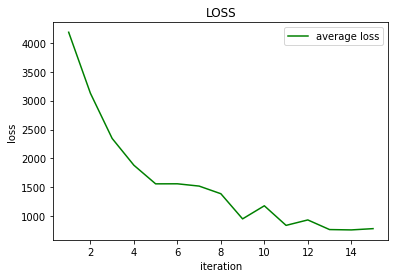

In [42]:
_ = plt.plot(axis, losses, label = 'average loss', color = 'green')
__ = plt.xlabel('iteration') 
___ = plt.ylabel('loss')
____ = plt.title('LOSS')
_____ = plt.legend()

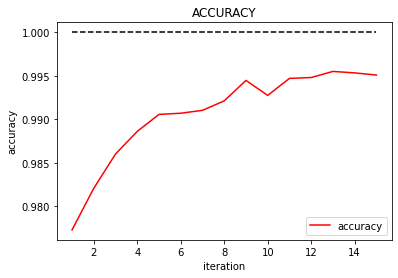

In [43]:
_ = plt.plot(axis, one, linestyle = 'dashed', color = 'black')
_ = plt.plot(axis, accuracies, label = 'accuracy', color = 'red')
__ = plt.xlabel('iteration') 
___ = plt.ylabel('accuracy')
____ = plt.title('ACCURACY')
_____ = plt.legend()

Now it is possible to observe better performance. Still, one can deduce that we probably have reached a maximum in the accuracy in the last steps of the pruning procedure. 
One could decrease the pruning rate and increase the number of epochs and the number of iteration to obtain better results.